In [1]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from env import user, pwd,host
import env

import wrangle_zillow as wz
import wranglerer as wrr
from sklearn.model_selection import train_test_split
import os
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import r2_score

# Acquire/Prepare/Explore

local version found!


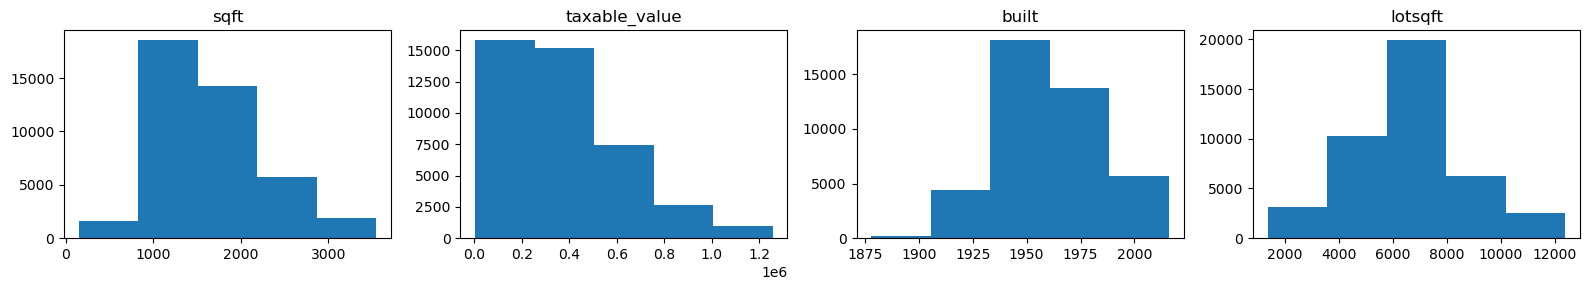

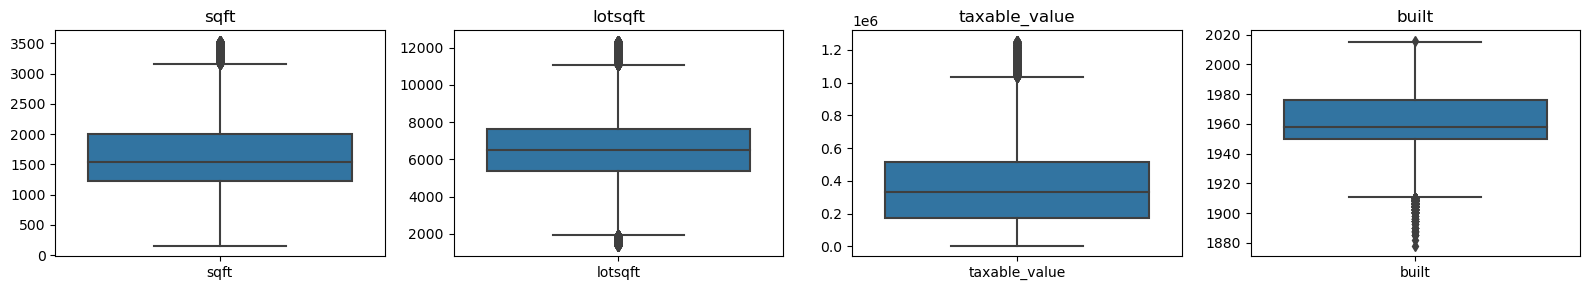

In [2]:
train_all,validate_all,test_all = wz.wrangle_zillow()

In [3]:
train_all['fips'] = train_all.fips.astype(int).astype(object)
train_all.fips.dtype

dtype('O')

In [4]:
train_all['beds'] = train_all.beds.astype(int)
train_all.beds.dtype

dtype('int64')

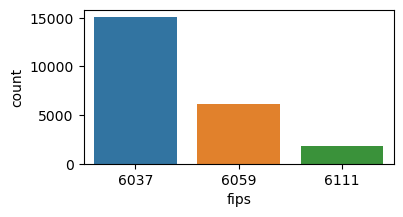

6037    15085
6059     6179
6111     1872
Name: fips, dtype: int64

In [5]:
plt.figure(figsize=(4,2))
sns.countplot(train_all['fips']) # 37 is la cnty, 59 is orange cnty, 111 is ventura cnty VERY IMBALANCE
plt.show()
train_all.fips.value_counts()

In [6]:
train_all[train_all.fips == 6111].taxable_value.mean()

409160.3637820513

In [7]:
train_all[train_all.fips == 6059].taxable_value.mean()

447285.98171225114

In [8]:
train_all[train_all.fips == 6037].taxable_value.mean()

333879.3561816374

In [9]:
train_all.taxable_value.mean()

370258.40119294607

## Check for statistical significance for LA CNTY vs OVERALL
### T-Test Independence 1-sample, 2-tail

## Due to CLT and large sample size > 500: assumption of "normality" is no longer a factor

### Hypothesis

- ${H_0}$: No statistically significant difference exists between mean Taxable_Values in LA County and the mean of all others.
- ${H_a}$: A statistically significant difference exists between mean Taxable_Values in LA County and the mean of all others.

#### Two-tailed, One-Sample T-Test ANY DIFF in mean between a subset and overall

In [10]:
train_all[train_all.fips == 6037].taxable_value.mean()

333879.3561816374

In [11]:
train_all.taxable_value.mean()

370258.40119294607

In [12]:
α = 0.05
lacnty_taxable_values = train_all[train_all.fips == 6037].taxable_value
overall_mean = train_all.taxable_value.mean()
t, p = stats.ttest_1samp(lacnty_taxable_values,overall_mean)
print(t,p,α)

-18.26322060553196 1.0105590708760435e-73 0.05


In [13]:
print(f'p = {p:e}')

p = 1.010559e-73


# Reject the NULL
### A statistically significant difference exists, there is evidence to suggest that the two samples were drawn from two distinct distributions.

In [14]:
train = train_all[train_all['fips'] == 6037]
validate = validate_all[validate_all['fips'] == 6037]
test = test_all[test_all['fips'] == 6037]

In [15]:
train.shape,validate.shape,test.shape

((15085, 8), (6370, 8), (5355, 8))

In [16]:
train.shape,validate.shape,test.shape

((15085, 8), (6370, 8), (5355, 8))

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15085 entries, 49580 to 38303
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   beds           15085 non-null  int64  
 1   baths          15085 non-null  float64
 2   sqft           15085 non-null  float64
 3   taxable_value  15085 non-null  float64
 4   built          15085 non-null  float64
 5   lotsqft        15085 non-null  float64
 6   fips           15085 non-null  object 
 7   city           15085 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.0+ MB


In [18]:
train.describe()

,beds,baths,sqft,taxable_value,built,lotsqft
count,15085.000000,15085.000000,15085.000000,1.508500e+04,15085.000000,15085.000000
mean,3.048326,1.929864,1541.106530,3.338794e+05,1954.340537,6739.085184
std,0.804875,0.738646,547.611107,2.446508e+05,21.381130,1891.061264
min,1.000000,1.000000,326.000000,3.254000e+03,1878.000000,1359.000000
25%,3.000000,1.000000,1149.000000,1.430100e+05,1944.000000,5502.000000
50%,3.000000,2.000000,1438.000000,2.808100e+05,1953.000000,6517.000000
75%,4.000000,2.000000,1822.000000,4.562450e+05,1963.000000,7662.000000
max,5.000000,4.000000,3546.000000,1.255000e+06,2016.000000,12385.000000


In [19]:
train.isnull().sum()

beds             0
baths            0
sqft             0
taxable_value    0
built            0
lotsqft          0
fips             0
city             0
dtype: int64

<AxesSubplot:>

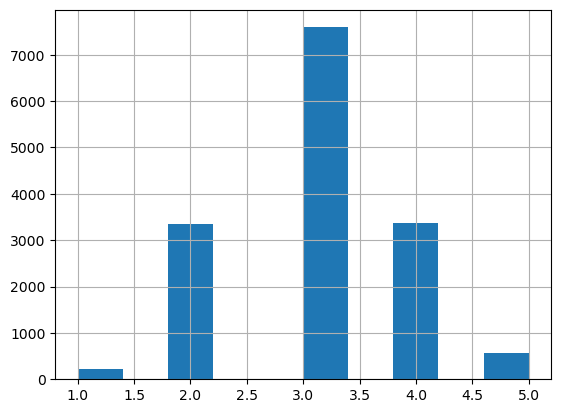

In [20]:
train['beds'].hist()

In [21]:
train['o_sqft'] = round(train['sqft'] / (train.beds + train.baths),0)
validate['o_sqft'] = round(validate['sqft'] / (validate.beds + validate.baths),0)
test['o_sqft'] = round(test['sqft'] / (test.beds + test.baths),0)

In [22]:
train.head()

,beds,baths,sqft,taxable_value,built,lotsqft,fips,city,o_sqft
49580,5,3.0,3000.0,305487.0,2005.0,6674.0,6037,5534.0,375.0
37700,2,1.0,1194.0,232682.0,1949.0,6702.0,6037,24174.0,398.0
26686,3,2.0,1706.0,92573.0,1951.0,5974.0,6037,118225.0,341.0
20095,3,2.0,1541.0,294404.0,1946.0,6202.0,6037,12447.0,308.0
43704,3,2.0,1308.0,169691.0,1944.0,5460.0,6037,12292.0,262.0


In [23]:
train.baths.value_counts().sort_index()

1.0    4403
2.0    7615
3.0    2789
4.0     278
Name: baths, dtype: int64

In [24]:
train.beds.value_counts().sort_index()

1     211
2    3346
3    7591
4    3377
5     560
Name: beds, dtype: int64

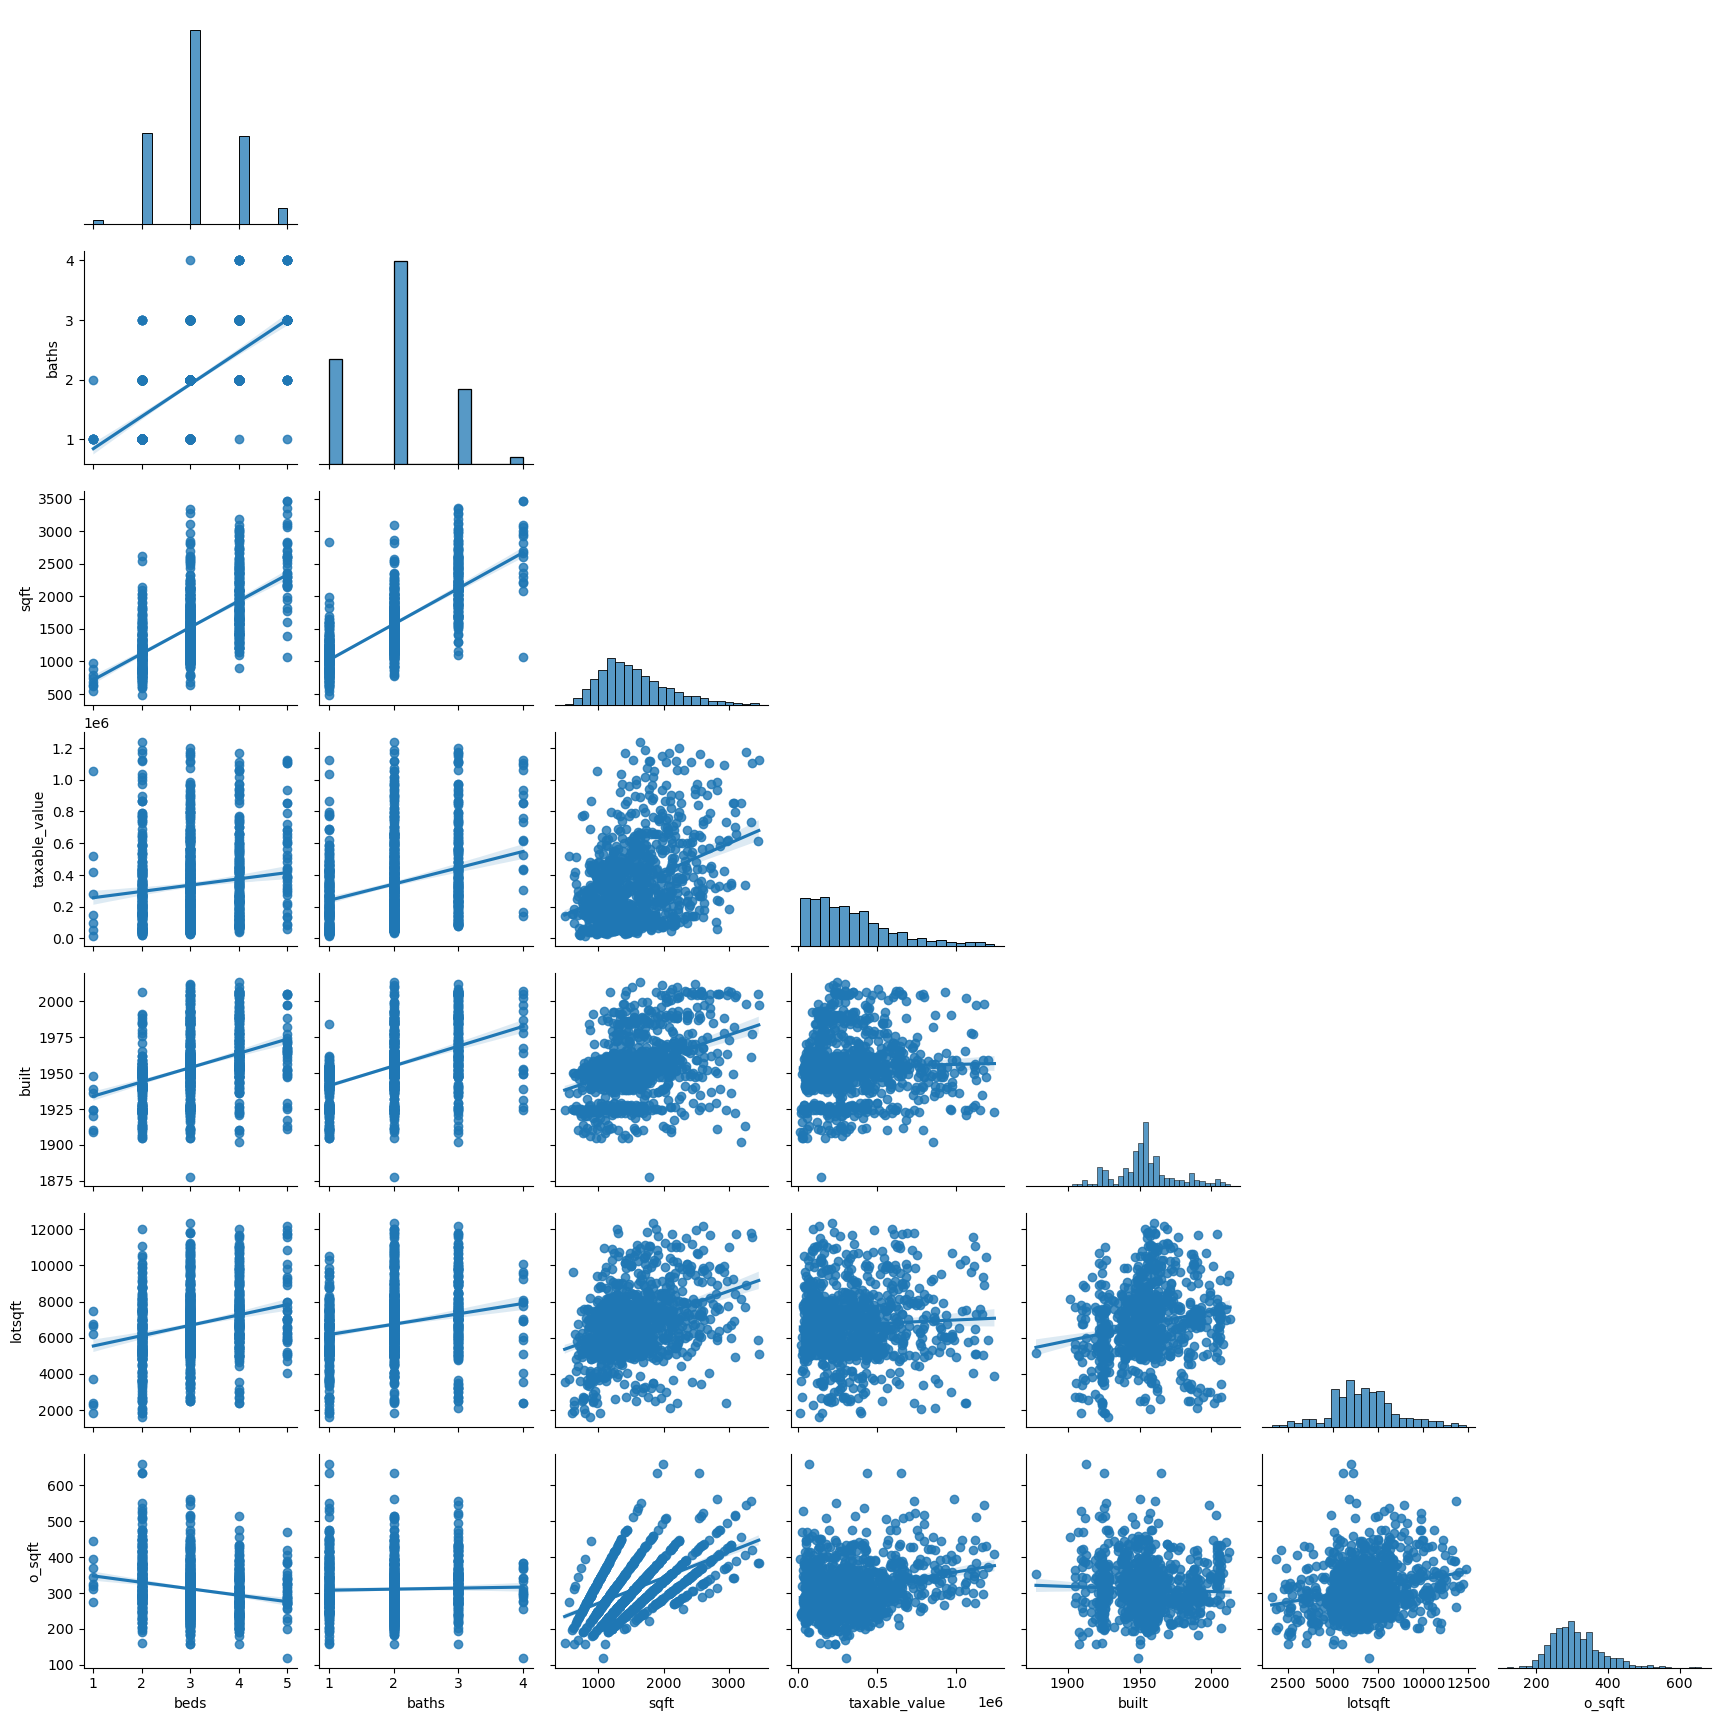

In [25]:
train_1k = train.drop(columns=['fips','city']).sample(1_000)
sns.pairplot(train_1k,corner=True,kind='reg')

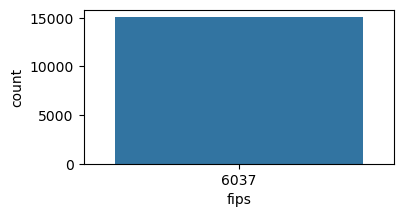

6037    15085
Name: fips, dtype: int64

In [26]:
plt.figure(figsize=(4,2))
sns.countplot(train['fips']) # 37 is la cnty, 59 is orange cnty, 111 is ventura cnty VERY IMBALANCE
plt.show()
train.fips.value_counts()

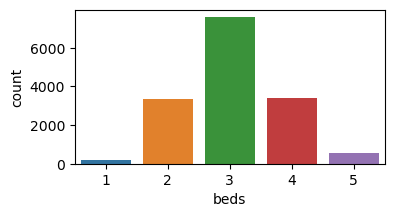

3    0.503215
4    0.223865
2    0.221810
5    0.037123
1    0.013987
Name: beds, dtype: float64

In [27]:
plt.figure(figsize=(4,2))
sns.countplot(train['beds']) # 37 is la cnty, 59 is orange cnty, 111 is ventura cnty VERY IMBALANCE
plt.show()
train.beds.value_counts(normalize=True)

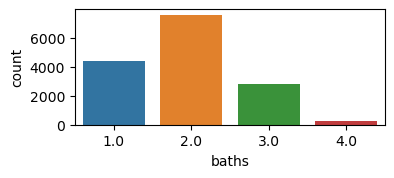

2.0    0.504806
1.0    0.291879
3.0    0.184886
4.0    0.018429
Name: baths, dtype: float64

In [28]:
plt.figure(figsize=(4,1.5))
sns.countplot(train['baths']) # 37 is la cnty, 59 is orange cnty, 111 is ventura cnty VERY IMBALANCE
plt.show()
train.baths.value_counts(normalize=True)

In [29]:
train.city.value_counts()

12447.0    4985
5534.0      812
46298.0     769
40227.0     662
54311.0     391
           ... 
15237.0       1
21395.0       1
36078.0       1
44833.0       1
14906.0       1
Name: city, Length: 114, dtype: int64

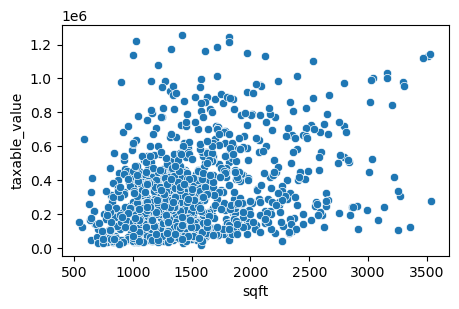

In [30]:
train_1000 = train.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='sqft',y='taxable_value')
plt.show()

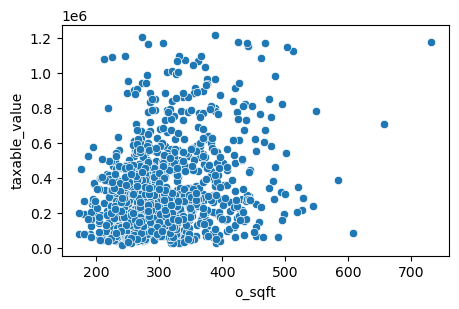

In [31]:
train_1000 = train.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='o_sqft',y='taxable_value')
plt.show()

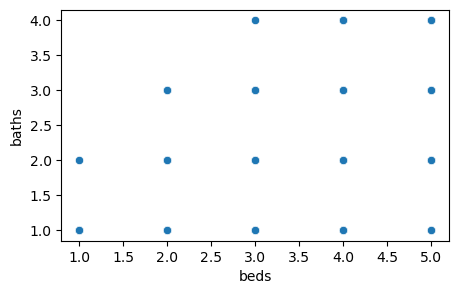

In [32]:
train_1000 = train.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='beds',y='baths')
plt.show()

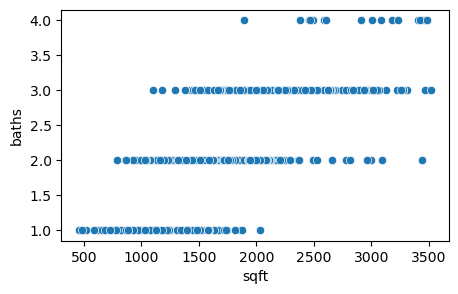

In [33]:
train_1000 = train.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='sqft',y='baths')
plt.show()

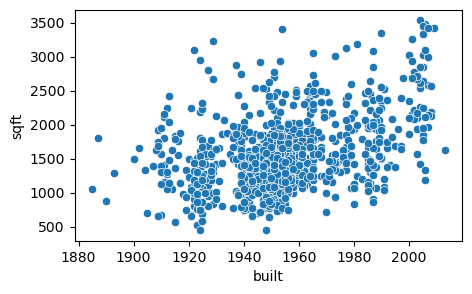

In [34]:
train_1000 = train.sample(1000)
plt.figure(figsize=(5,3))
sns.scatterplot(data=train_1000, x='built',y='sqft')
plt.show()

In [35]:
train[train.fips == 6037].taxable_value.mean()

333879.3561816374

In [36]:
train.taxable_value.mean()

333879.3561816374

# Evaluate
### First model uses sqft, beds, baths

In [37]:
#import sklearn mean_square_error

from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score

In [38]:
X_train,y_train = train.drop(columns='taxable_value'), train[['taxable_value']]
X_validate,y_validate = validate.drop(columns='taxable_value'), validate[['taxable_value']]
X_test,y_test = test.drop(columns='taxable_value'), test[['taxable_value']]

In [39]:
X_train.head()

,beds,baths,sqft,built,lotsqft,fips,city,o_sqft
49580,5,3.0,3000.0,2005.0,6674.0,6037,5534.0,375.0
37700,2,1.0,1194.0,1949.0,6702.0,6037,24174.0,398.0
26686,3,2.0,1706.0,1951.0,5974.0,6037,118225.0,341.0
20095,3,2.0,1541.0,1946.0,6202.0,6037,12447.0,308.0
43704,3,2.0,1308.0,1944.0,5460.0,6037,12292.0,262.0


In [40]:
model_1_feats = ['sqft',
                'beds',
                'baths']
X_train_1 = X_train[model_1_feats]
X_validate_1 = X_validate[model_1_feats]
X_test_1 = X_test[model_1_feats]

In [41]:
X_train_1.shape, X_validate_1.shape, X_test_1.shape

((15085, 3), (6370, 3), (5355, 3))

In [42]:
X_train_1.head()

,sqft,beds,baths
49580,3000.0,5,3.0
37700,1194.0,2,1.0
26686,1706.0,3,2.0
20095,1541.0,3,2.0
43704,1308.0,3,2.0


In [43]:
y_train.head()

,taxable_value
49580,305487.0
37700,232682.0
26686,92573.0
20095,294404.0
43704,169691.0


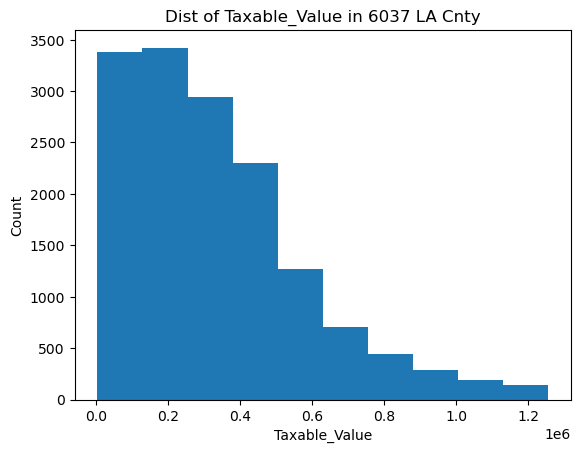

In [44]:
plt.hist(y_train)
plt.title('Dist of Taxable_Value in 6037 LA Cnty')
plt.xlabel("Taxable_Value")
plt.ylabel("Count")

plt.show()

In [45]:
# convert y_targets into dataframe so that we can append additional columns to it
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [46]:
# 1. Predict target_pred_mean
target_pred_mean = y_train.taxable_value.mean()
y_train['target_pred_mean'] = target_pred_mean
y_validate['target_pred_mean'] = target_pred_mean

In [47]:
y_train.head()

,taxable_value,target_pred_mean
49580,305487.0,333879.356182
37700,232682.0,333879.356182
26686,92573.0,333879.356182
20095,294404.0,333879.356182
43704,169691.0,333879.356182


In [48]:
# 2. compute target_pred_median
target_pred_median = y_train.taxable_value.median()
y_train['target_pred_median'] = target_pred_median
y_validate['target_pred_median'] = target_pred_median

In [49]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_median
49580,305487.0,333879.356182,280810.0
37700,232682.0,333879.356182,280810.0
26686,92573.0,333879.356182,280810.0
20095,294404.0,333879.356182,280810.0
43704,169691.0,333879.356182,280810.0


In [50]:
# COMPARE mu and median
rmse_train_mean = mean_squared_error(y_train.taxable_value,
                                y_train.target_pred_mean) ** .5

rmse_validate_mean = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_mean) ** (0.5)

rmse_train_med = mean_squared_error(y_train.taxable_value, y_train.target_pred_median) ** .5
rmse_validate_med = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_median) ** (0.5)

print(f"""RMSE using Mean
Train/In-Sample: {round(rmse_train_mean, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_mean, 2)}""")

print(f"""RMSE using Median
Train/In-Sample: {round(rmse_train_med, 2)} 
Validate/Out-of-Sample: {round(rmse_validate_med, 2)}""")

# We actually want to use the MEAN 244k vs 250k

RMSE using Mean
Train/In-Sample: 244642.66 
Validate/Out-of-Sample: 243038.47
RMSE using Median
Train/In-Sample: 250332.55 
Validate/Out-of-Sample: 249272.63


In [51]:
# Drop Median...remove unnecessary clutter
y_train = y_train.drop(columns='target_pred_median')

In [52]:
y_train.head()

,taxable_value,target_pred_mean
49580,305487.0,333879.356182
37700,232682.0,333879.356182
26686,92573.0,333879.356182
20095,294404.0,333879.356182
43704,169691.0,333879.356182


In [53]:
# build a quick df to compare results...will append to this df as needed
metric_df = pd.DataFrame(data=[
    {'model': 'mean_baseline',
     'RMSE_train': rmse_train_mean,
     'RMSE_validate': rmse_validate_mean,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_mean)
    }
]
)

In [54]:
# MEAN_baseline
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.0


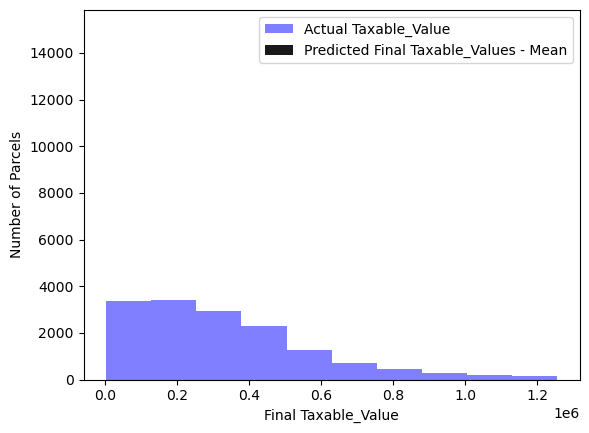

In [55]:
# plot to visualize actual vs predicted. 

plt.hist(y_train.taxable_value, color='blue', alpha=.5, label="Actual Taxable_Value")
plt.hist(y_train.target_pred_mean, bins=1, color='black', alpha=.9,  label="Predicted Final Taxable_Values - Mean")
#plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=.5, label="Predicted Final Grades - Median")
plt.xlabel("Final Taxable_Value")
plt.ylabel("Number of Parcels")
plt.legend()
plt.show()

## OLS Model 1 with required features: sqft, beds, baths

In [56]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train_1, y_train.taxable_value)

#2. USE THE THING: make a prediction
y_train['target_pred_lm'] = lm.predict(X_train_1)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_lm)**(1/2)

In [57]:
#4. REPEAT STEPS 2-3

# predict validate
y_validate['target_pred_lm'] = lm.predict(X_validate_1)


# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_lm)**(1/2)


print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  227358.360737476 
Validation/Out-of-Sample: 225182.72442983423


In [58]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_lm
49580,305487.0,333879.356182,523881.248712
37700,232682.0,333879.356182,298832.110710
26686,92573.0,333879.356182,366475.981356
20095,294404.0,333879.356182,337822.870014
43704,169691.0,333879.356182,297361.203694


In [59]:
#Append this to the metric_df

metric_df = metric_df.append(
    {'model': 'OLS Regressor',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_lm)
    }, ignore_index=True)

In [60]:
# R2 with the OLS Model features: sqft, beds, baths in LA CNTY is 14.1%
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491


In [61]:
#take a look under the hood 
coef_df = pd.DataFrame({'cols':X_train_1.columns,
              'OLScoef':OLSmodel.coef_})

In [62]:
coef_df

,cols,OLScoef
0,sqft,173.655220
1,beds,-46036.985532
2,baths,24769.383406


### ok...try OLS  MODEL2 with all three combined into one feature: o_sqft

In [63]:
model_2_feats = ['o_sqft']
X_train_2 = X_train[model_2_feats]
X_validate_2 = X_validate[model_2_feats]
X_test_2 = X_test[model_2_feats]

In [64]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train_2, y_train.taxable_value)

#2. USE THE THING: make a prediction
y_train['target_pred_lm2'] = lm.predict(X_train_2)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_lm2)**(1/2)


In [65]:
#4. REPEAT STEPS 2-3

# predict validate
y_validate['target_pred_lm2'] = lm.predict(X_validate_2)


# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_lm2)**(1/2)


print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  237314.24055482866 
Validation/Out-of-Sample: 235095.47902282866


In [66]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_lm,target_pred_lm2
49580,305487.0,333879.356182,523881.248712,388462.748435
37700,232682.0,333879.356182,298832.110710,408073.434663
26686,92573.0,333879.356182,366475.981356,359473.038357
20095,294404.0,333879.356182,337822.870014,331335.966811
43704,169691.0,333879.356182,297361.203694,292114.594354


In [67]:
#Append this to the metric_df

metric_df = metric_df.append(
    {'model': 'OLS Regressor 2',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_lm2)
    }, ignore_index=True)

In [68]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264


In [69]:
OLSmodel.coef_

array([852.63853169])

### ok...try OLS  MODEL3 with only one feature: baths

In [70]:
model_3_feats = ['baths']
X_train_3 = X_train[model_3_feats]
X_validate_3 = X_validate[model_3_feats]
X_test_3 = X_test[model_3_feats]

In [71]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train_3, y_train.taxable_value)

#2. USE THE THING: make a prediction
y_train['target_pred_lm3'] = lm.predict(X_train_3)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_lm3)**(1/2)


In [72]:
#4. REPEAT STEPS 2-3

# predict validate
y_validate['target_pred_lm3'] = lm.predict(X_validate_3)


# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_lm3)**(1/2)


print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  234747.54803102525 
Validation/Out-of-Sample: 232893.65017879012


In [73]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_lm,target_pred_lm2,target_pred_lm3
49580,305487.0,333879.356182,523881.248712,388462.748435,433665.903145
37700,232682.0,333879.356182,298832.110710,408073.434663,247172.678721
26686,92573.0,333879.356182,366475.981356,359473.038357,340419.290933
20095,294404.0,333879.356182,337822.870014,331335.966811,340419.290933
43704,169691.0,333879.356182,297361.203694,292114.594354,340419.290933


In [74]:
#Append this to the metric_df

metric_df = metric_df.append(
    {'model': 'OLS Regressor 3',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_lm3)
    }, ignore_index=True)

In [75]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727


In [76]:
OLSmodel.coef_

array([93246.61221182])

### ok...try DTR  MODEL4 with all features 

In [77]:
X_train.head()

,beds,baths,sqft,built,lotsqft,fips,city,o_sqft
49580,5,3.0,3000.0,2005.0,6674.0,6037,5534.0,375.0
37700,2,1.0,1194.0,1949.0,6702.0,6037,24174.0,398.0
26686,3,2.0,1706.0,1951.0,5974.0,6037,118225.0,341.0
20095,3,2.0,1541.0,1946.0,6202.0,6037,12447.0,308.0
43704,3,2.0,1308.0,1944.0,5460.0,6037,12292.0,262.0


In [78]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(max_depth=3)
DTR.fit(X_train,y_train.taxable_value)

DecisionTreeRegressor(max_depth=3)

In [79]:
y_train['target_pred_DTR'] = DTR.predict(X_train)

In [80]:
DTR.predict(X_train)

array([300670.37857143, 313065.22661871, 412650.37988561, ...,
       412650.37988561, 412650.37988561, 313065.22661871])

In [81]:
r2_score(y_train.taxable_value,y_train.target_pred_DTR)

0.15031973627154815

In [82]:
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_DTR)**(1/2)

In [83]:
#4. REPEAT STEPS 2-3

# predict validate
y_validate['target_pred_DTR'] = DTR.predict(X_validate)


# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_DTR)**(1/2)


print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

RMSE for OLS using LinearRegression
Training/In-Sample:  225506.96305523842 
Validation/Out-of-Sample: 225620.5136226508


In [84]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_lm,target_pred_lm2,target_pred_lm3,target_pred_DTR
49580,305487.0,333879.356182,523881.248712,388462.748435,433665.903145,300670.378571
37700,232682.0,333879.356182,298832.110710,408073.434663,247172.678721,313065.226619
26686,92573.0,333879.356182,366475.981356,359473.038357,340419.290933,412650.379886
20095,294404.0,333879.356182,337822.870014,331335.966811,340419.290933,313065.226619
43704,169691.0,333879.356182,297361.203694,292114.594354,340419.290933,313065.226619


In [85]:
#Append this to the metric_df

metric_df = metric_df.append(
    {'model': 'DT Regressor 4',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_DTR)
    }, ignore_index=True)

In [86]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184


----
----
----

In [87]:
# VANILLA TREE WITH EXPECTED OVERFIT
DTR2 = DecisionTreeRegressor()
DTR2.fit(X_train,y_train.taxable_value)
y_train['target_pred_DTR2'] = DTR2.predict(X_train)
DTR2.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_DTR2)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_DTR2'] = DTR2.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_DTR2)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_DTR2)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'DT Regressor 5',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_DTR2)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  3859.368634128317 
Validation/Out-of-Sample: 297576.13096521446
R2 Score: 0.999751132523602


In [88]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236


In [93]:
y_train.head()

,taxable_value,target_pred_mean,target_pred_lm,target_pred_lm2,target_pred_lm3,target_pred_DTR,target_pred_DTR2
49580,305487.0,333879.356182,523881.248712,388462.748435,433665.903145,300670.378571,305487.0
37700,232682.0,333879.356182,298832.110710,408073.434663,247172.678721,313065.226619,232682.0
26686,92573.0,333879.356182,366475.981356,359473.038357,340419.290933,412650.379886,92573.0
20095,294404.0,333879.356182,337822.870014,331335.966811,340419.290933,313065.226619,294404.0
43704,169691.0,333879.356182,297361.203694,292114.594354,340419.290933,313065.226619,169691.0


---
----
----

# Feature Importance with Select K Best and RFE

In [94]:
# make the thing

kbest = SelectKBest(f_regression,k=4)

# fit the thing
_ = kbest.fit(X_train,y_train.taxable_value)

In [95]:
# statistical f-value:
kbest.scores_
#p value: 
#kbest.pvalues_  # exam 1 and exam3 based upon greater F_SCORES!!!

array([ 295.33000794, 1298.36109435, 2112.71318217,    7.16916116,
        101.32580531,    0.        ,    2.52488653,  945.92930314])

In [96]:
X_train.columns[kbest.get_support()]

Index(['beds', 'baths', 'sqft', 'o_sqft'], dtype='object')

In [97]:
kbest.get_support()
X_train.iloc[:,kbest.get_support()].head()

,beds,baths,sqft,o_sqft
49580,5,3.0,3000.0,375.0
37700,2,1.0,1194.0,398.0
26686,3,2.0,1706.0,341.0
20095,3,2.0,1541.0,308.0
43704,3,2.0,1308.0,262.0


### RFE

In [98]:
# establish a model for RFE to use

model = LinearRegression()
# make an RFE thing
rfe = RFE(model, n_features_to_select=4)
# fit the RFE thing
rfe.fit(X_train,y_train.taxable_value)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [99]:
pd.DataFrame({
    'rfe_ranking':rfe.ranking_
}, index=X_train.columns)

,rfe_ranking
beds,1
baths,1
sqft,1
built,1
lotsqft,3
fips,5
city,4
o_sqft,2


In [100]:
pd.DataFrame(rfe.transform(X_train),
            columns=X_train.columns[rfe.get_support()],index=X_train.index).head()

,beds,baths,sqft,built
49580,5,3.0,3000.0,2005.0
37700,2,1.0,1194.0,1949.0
26686,3,2.0,1706.0,1951.0
20095,3,2.0,1541.0,1946.0
43704,3,2.0,1308.0,1944.0


---
----
----

# playtime with DTR

In [104]:
DTRp = DecisionTreeRegressor(max_depth=7)
DTRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_DTRp'] = DTRp.predict(X_train)
DTRp.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_DTRp)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_DTRp'] = DTRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_DTRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_DTRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'DT Regressor p',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_DTRp)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  214009.03323881174 
Validation/Out-of-Sample: 220582.90635474736
R2 Score: 0.23475618464254044


In [105]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236
6,DT Regressor p,214009.033239,220582.906355,0.176278


In [103]:
# metric_df.drop([6],inplace=True)
# metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236


In [ ]:
from sklearn.ensemble import RandomForestRegressor

---
----
----

# playtime with RFR

In [106]:
from sklearn.ensemble import RandomForestRegressor

RFRp = RandomForestRegressor(n_estimators=55, max_depth=10,random_state=2013)
RFRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_RFRp'] = RFRp.predict(X_train)
RFRp.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_RFRp)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_RFRp'] = RFRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_RFRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_RFRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'RF Regressor p',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_RFRp)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  190455.2690957028 
Validation/Out-of-Sample: 211546.43215037603
R2 Score: 0.39393165327984503


In [107]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236
6,DT Regressor p,214009.033239,220582.906355,0.176278
7,RF Regressor p,190455.269096,211546.432150,0.242346


In [ ]:
# metric_df.drop([6],inplace=True)
# metric_df

---
----
----

# playtime with CATBoost

In [108]:
from catboost import CatBoostRegressor

In [142]:
from catboost import CatBoostRegressor

CATb = CatBoostRegressor(verbose=False,max_depth=4)
CATb.fit(X_train,y_train.taxable_value)
y_train['target_pred_CATb'] = CATb.predict(X_train)
CATb.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_CATb)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_CATb'] = CATb.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_CATb)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_CATb)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'CATBoostR MaxD = 4',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_CATb)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  202171.9334767162 
Validation/Out-of-Sample: 208267.26570240557
R2 Score: 0.3170681820532101


In [143]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236
6,DT Regressor p,214009.033239,220582.906355,0.176278
7,RF Regressor p,190455.269096,211546.432150,0.242346
8,CATBoostR Vanilla,202171.933477,208267.265702,0.265627


In [144]:
# metric_df.drop([8],inplace=True)
# metric_df

# Lets focus on FIPS 6111 VENTURA CNTY
### Lets just run a quick RFR to see if it is worthy of further attention w/ 55 trees and max_depth = 10
### Further tuning leads to better results with 101 estimators and mx_depth = 8

In [145]:
validate_all.fips.value_counts()

6037.0    6370
6059.0    2709
6111.0     837
Name: fips, dtype: int64

In [146]:
train = train_all[train_all['fips'] == 6111]
validate= validate_all[validate_all['fips'] == 6111]
test = test_all[test_all['fips'] == 6111]

In [147]:
validate.fips.value_counts()

6111.0    837
Name: fips, dtype: int64

In [148]:
train.shape,validate.shape,test.shape

((1872, 8), (837, 8), (678, 8))

In [149]:
train.head()

,beds,baths,sqft,taxable_value,built,lotsqft,fips,city
32183,4,2.0,2067.0,504510.0,1970.0,10096.0,6111,53655.0
43385,3,2.0,1579.0,514000.0,1974.0,6405.0,6111,34543.0
51496,3,1.0,1274.0,515000.0,1954.0,7644.0,6111,13091.0
1624,5,3.5,3128.0,947000.0,1976.0,8289.0,6111,41673.0
10607,3,2.0,1684.0,579000.0,1979.0,9022.0,6111,40110.0


In [150]:
X_train,y_train = train.drop(columns='taxable_value'), train[['taxable_value']]
X_validate,y_validate = validate.drop(columns='taxable_value'), validate[['taxable_value']]
X_test,y_test = test.drop(columns='taxable_value'), test[['taxable_value']]

In [151]:
X_train.head()

,beds,baths,sqft,built,lotsqft,fips,city
32183,4,2.0,2067.0,1970.0,10096.0,6111,53655.0
43385,3,2.0,1579.0,1974.0,6405.0,6111,34543.0
51496,3,1.0,1274.0,1954.0,7644.0,6111,13091.0
1624,5,3.5,3128.0,1976.0,8289.0,6111,41673.0
10607,3,2.0,1684.0,1979.0,9022.0,6111,40110.0


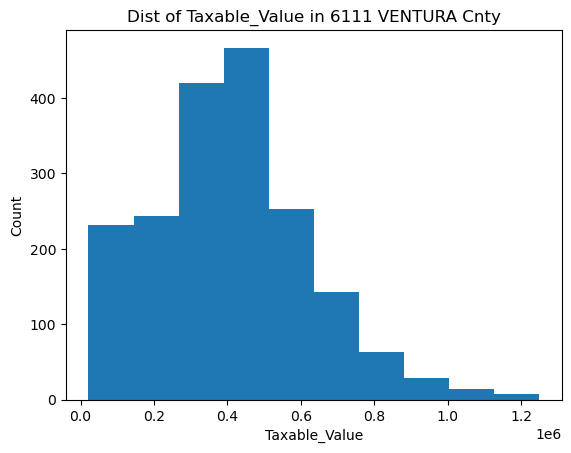

In [152]:
plt.hist(y_train)
plt.title('Dist of Taxable_Value in 6111 VENTURA Cnty')
plt.xlabel("Taxable_Value")
plt.ylabel("Count")

plt.show()

In [153]:

RFRp = RandomForestRegressor(n_estimators=101, max_depth=7,random_state=2013)
RFRp.fit(X_train,y_train.taxable_value)
y_train['target_pred_RFRp'] = RFRp.predict(X_train)
RFRp.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_RFRp)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_RFRp'] = RFRp.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_RFRp)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_RFRp)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}
R2_validate: {explained_variance_score(y_validate.taxable_value,
                                              y_validate.target_pred_RFRp)}
""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'RF Regressor VENTURA',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_RFRp)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  131865.2945489587 
Validation/Out-of-Sample: 159461.61450915763
R2 Score: 0.6185596369114599
R2_validate: 0.4200587105793071



In [154]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236
6,DT Regressor p,214009.033239,220582.906355,0.176278
7,RF Regressor p,190455.269096,211546.432150,0.242346
8,RF Regressor VENTURA,131865.294549,159461.614509,0.420059


In [156]:
from catboost import CatBoostRegressor

CATb = CatBoostRegressor(verbose=False,max_depth=4)
CATb.fit(X_train,y_train.taxable_value)
y_train['target_pred_CATb'] = CATb.predict(X_train)
CATb.predict(X_train)
#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.taxable_value, y_train.target_pred_CATb)**(1/2)
#4. REPEAT STEPS 2-3
# predict validate
y_validate['target_pred_CATb'] = CATb.predict(X_validate)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.taxable_value, y_validate.target_pred_CATb)**(1/2)
r2 = r2_score(y_train.taxable_value,y_train.target_pred_CATb)
print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}
R2 Score: {r2}""")
#Append this to the metric_df
metric_df = metric_df.append(
    {'model': 'CATBoostR MaxD4 VENTURA',
     'RMSE_train': rmse_train,
     'RMSE_validate': rmse_validate,
     'R2_validate': explained_variance_score(y_validate.taxable_value,
                                             y_validate.target_pred_CATb)
    }, ignore_index=True)

RMSE for OLS using LinearRegression
Training/In-Sample:  124929.45645124895 
Validation/Out-of-Sample: 160024.09351634962
R2 Score: 0.6576302942446302


In [157]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,244642.660443,243038.465954,0.000000
1,OLS Regressor,227358.360737,225182.724430,0.141491
2,OLS Regressor 2,237314.240555,235095.479023,0.064264
3,OLS Regressor 3,234747.548031,232893.650179,0.081727
4,DT Regressor 4,225506.963055,225620.513623,0.138184
5,DT Regressor 5,3859.368634,297576.130965,-0.499236
6,DT Regressor p,214009.033239,220582.906355,0.176278
7,RF Regressor p,190455.269096,211546.432150,0.242346
8,RF Regressor VENTURA,131865.294549,159461.614509,0.420059
9,CATBoostR MaxD4 VENTURA,124929.456451,160024.093516,0.415720


---